# **Faster R-CNN Object Detection on Custom Pascal VOC Dataset**

This notebook demonstrates how to train a Faster R-CNN model using a custom dataset in Pascal VOC format. We will load annotated images from Google Drive, preprocess them, train a Faster R-CNN model, and visualize predictions.


---

## ** Mount Google Drive**

We mount Google Drive to access the dataset stored in a specific directory. This is essential for loading custom training and validation data saved on your Drive.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import Required Libraries**

Here, we import essential libraries for:
- File and directory handling (`os`, `xml`)
- PyTorch and torchvision for model and data handling
- PIL for image manipulation
- `tqdm` for progress visualization

---

#**Define Dataset and Transformations**

This section defines:
- A custom transformation (`ResizeTransform`) to resize both the image and bounding boxes.
- A dataset class (`VOCDataset`) that:
  - Parses Pascal VOC-style XML annotations.
  - Converts bounding boxes and labels into tensors compatible with PyTorch.

  ---

## **Prepare Dataset and DataLoader**

- Set image resize dimensions.
- Load training and validation datasets from Google Drive.
- Wrap datasets with DataLoader for batching and shuffling.

---

## **Load Pretrained Faster R-CNN Model**

We:
- Load a pretrained Faster R-CNN model with ResNet-50 FPN backbone.
- Replace the classifier head to fit our number of classes (9 + 1 for background).

---
## **Define Optimizer and Scheduler**

We use:
- Stochastic Gradient Descent (SGD) optimizer.
- StepLR scheduler to reduce learning rate after every 3 epochs.

---

## **Training Loop**

Run training for a specified number of epochs. For each epoch:
- The model is trained on batches of data.
- The total loss is calculated and printed.
- Learning rate is adjusted by the scheduler.





In [2]:
import os
import torch
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm

# Custom Transform to Resize Image and Bounding Boxes
class ResizeTransform:
    def __init__(self, size):
        self.size = size  # size: (height, width)

    def __call__(self, image, target):
        orig_w, orig_h = image.size
        image = image.resize(self.size)

        scale_x = self.size[0] / orig_w
        scale_y = self.size[1] / orig_h

        boxes = target['boxes']
        if boxes.numel() > 0:
            boxes[:, [0, 2]] *= scale_x  # x1, x2
            boxes[:, [1, 3]] *= scale_y  # y1, y2
        target['boxes'] = boxes

        return T.ToTensor()(image), target

# Dataset Class
class VOCDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]
        self.image_files = [f for f in self.image_files if os.path.exists(os.path.join(annotation_dir, os.path.splitext(f)[0] + ".xml"))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        xml_path = os.path.join(self.annotation_dir, os.path.splitext(img_filename)[0] + ".xml")

        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label_text = obj.find("name").text
            try:
                label_id = int(label_text.split("_")[-1])
                labels.append(label_id)
            except Exception as e:
                continue

            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target


# Setup transforms
resize_size = (640, 640)  # Resize images and adjust boxes accordingly
transform = ResizeTransform(size=resize_size)

# Dataset & DataLoader Setup
base_path = "/content/drive/MyDrive/CSM/DatasetVOC"
train_ds = VOCDataset(os.path.join(base_path, "train", "images"),
                      os.path.join(base_path, "train", "annotations"),
                      transforms=transform)
val_ds = VOCDataset(os.path.join(base_path, "valid", "images"),
                    os.path.join(base_path, "valid", "annotations"),
                    transforms=transform)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=2)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=2)


# Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

num_classes = 10  # Based on your labels: 1-indexed up to 9 + background = 10
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer & Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training Loop
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        avg_loss = train_loss / (progress_bar.n + 1)
        progress_bar.set_postfix({"Loss": avg_loss})

    lr_scheduler.step()
    print(f"Epoch {epoch+1} completed | Avg Loss: {train_loss / len(train_loader):.4f}")


Epoch 1 completed | Avg Loss: 1.2967


Epoch 2 completed | Avg Loss: 0.9963


Epoch 3 completed | Avg Loss: 0.8675


Epoch 4 completed | Avg Loss: 0.6747


Epoch 5 completed | Avg Loss: 0.6169


Epoch 6 completed | Avg Loss: 0.5826


Epoch 7 completed | Avg Loss: 0.5441


## **Define Visualization Function**

A helper function that:
- Runs inference on validation images.
- Plots predicted bounding boxes with confidence scores.

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def test_and_visualize(model, dataset, device, score_threshold=0.5, num_images=5):
    model.eval()
    for idx in range(num_images):
        img, _ = dataset[idx]  # (image, target) pair
        with torch.no_grad():
            prediction = model([img.to(device)])[0]

        img_np = F.to_pil_image(img)
        plt.imshow(img_np)
        ax = plt.gca()

        boxes = prediction['boxes'].cpu()
        scores = prediction['scores'].cpu()
        labels = prediction['labels'].cpu()

        for box, score, label in zip(boxes, scores, labels):
            if score >= score_threshold:
                x1, y1, x2, y2 = box
                ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                           fill=False, edgecolor='lime', linewidth=2))
                ax.text(x1, y1 - 5, f"{label.item()} ({score:.2f})",
                        fontsize=8, color='white', bbox=dict(facecolor='green', alpha=0.5))

        plt.axis('off')
        plt.title(f"Prediction {idx+1}")
        plt.show()


## **Run Inference on Validation Set**

Calls the visualization function to display predictions on 5 validation images.


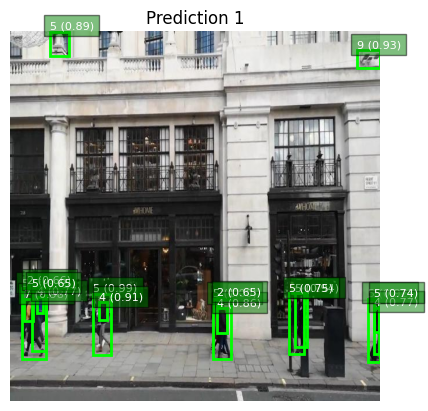

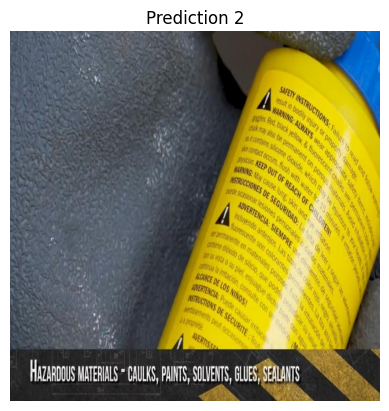

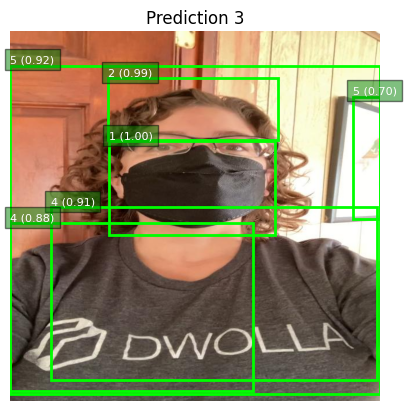

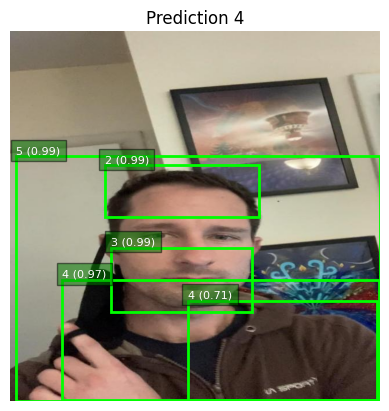

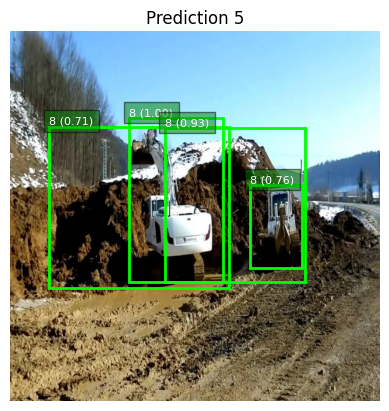

In [4]:
test_and_visualize(model, val_ds, device, score_threshold=0.5, num_images=5)

## **Naming the Class label for clear detection**

The objects are visualized with their name in bounded box.

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch

def run_inference_on_image(image_path, model, device, resize_size=(640, 640), score_threshold=0.5):
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    orig_w, orig_h = image.size
    image_resized = image.resize(resize_size)

    # Convert to tensor
    image_tensor = F.to_tensor(image_resized).to(device)

    with torch.no_grad():
        outputs = model([image_tensor])[0]

    # Display image
    plt.figure(figsize=(10, 8))
    plt.imshow(image_resized)
    ax = plt.gca()

    boxes = outputs['boxes'].cpu()
    scores = outputs['scores'].cpu()
    labels = outputs['labels'].cpu()

    for box, score, label in zip(boxes, scores, labels):
        if score >= score_threshold:
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       fill=False, edgecolor='lime', linewidth=2))
            ax.text(x1, y1 - 5, f"{label.item()} ({score:.2f})",
                    fontsize=10, color='white', bbox=dict(facecolor='green', alpha=0.5))

    plt.axis('off')
    plt.title(f"Predictions on {os.path.basename(image_path)}")
    plt.show()


In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch

# Your label map
label_map = {
    1: 'Mask',
    2: 'No hardhat',
    3: 'No mask',
    4: 'No vest',
    5: 'Person',
    6: 'Cone',
    7: 'Vest',
    8: 'Machinery',
    9: 'Vehicle'
}

def run_inference_on_image(image_path, model, device, resize_size=(640, 640), score_threshold=0.5):
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_resized = image.resize(resize_size)

    # Convert to tensor and send to device
    image_tensor = F.to_tensor(image_resized).to(device)

    # Inference
    with torch.no_grad():
        outputs = model([image_tensor])[0]

    # Setup plot
    plt.figure(figsize=(10, 8))
    plt.imshow(image_resized)
    ax = plt.gca()

    boxes = outputs['boxes'].cpu()
    scores = outputs['scores'].cpu()
    labels = outputs['labels'].cpu()

    for box, score, label in zip(boxes, scores, labels):
        if score >= score_threshold:
            x1, y1, x2, y2 = box
            ax.add_patch(
                plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              fill=False, edgecolor='lime', linewidth=2)
            )
            label_text = f"{label_map.get(label.item(), label.item())} ({score:.2f})"
            ax.text(x1, y1 - 5, label_text,
                    fontsize=10, color='white',
                    bbox=dict(facecolor='green', alpha=0.5))

    plt.axis('off')
    plt.title(f"Predictions on {os.path.basename(image_path)}")
    plt.show()


In [14]:
# Save the model after training
torch.save(model.state_dict(), 'Csm_Model.pth')
print("Model saved as Csm_Model.pth")

Model saved as Csm_Model.pth


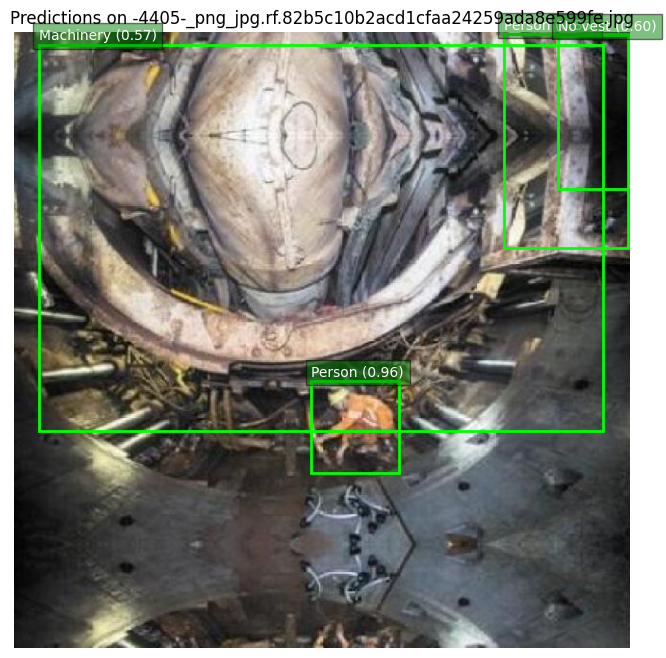

In [8]:
run_inference_on_image("/content/drive/MyDrive/CSM/DatasetVOC/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg", model, device)

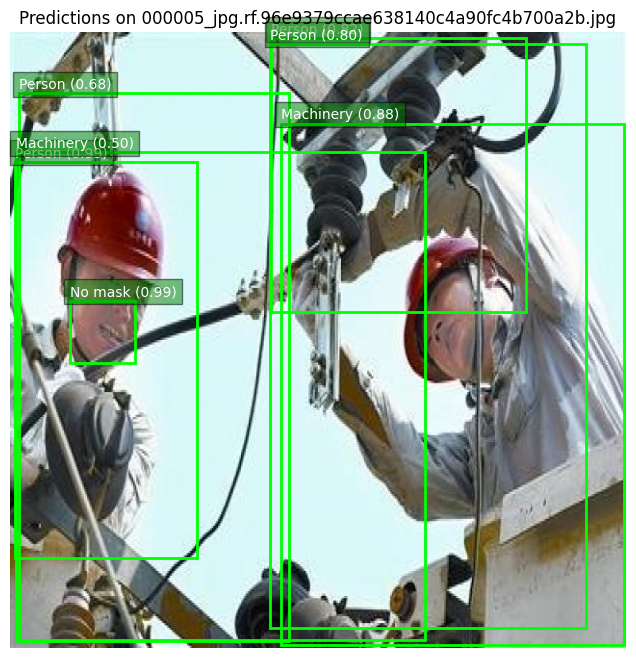

In [11]:
run_inference_on_image("/content/drive/MyDrive/CSM/DatasetVOC/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg", model, device)

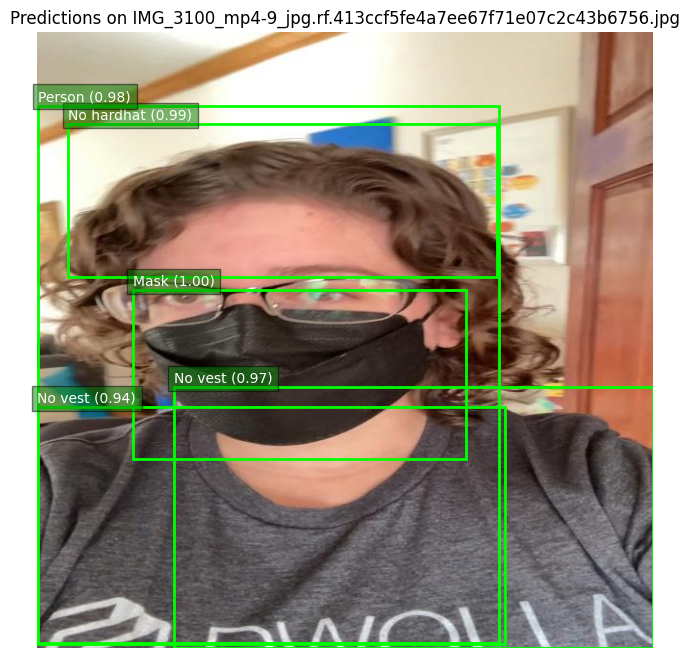

In [13]:
run_inference_on_image("/content/drive/MyDrive/CSM/DatasetVOC/test/images/2008_008320_jpg.rf.bd34011d46f82f9410d95f00e560b8ea.jpg", model, device)